<a href="https://colab.research.google.com/github/vdinni/MachineLearning/blob/master/CovidClaheViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
#!pip install -q kaggle
!rm -r covid_new

In [2]:
#files.upload()

!unzip /content/drive/MyDrive/covid-cxr-image-dataset-research_origin.zip

Archive:  /content/drive/MyDrive/covid-cxr-image-dataset-research_origin.zip
  inflating: COVID_IEEE/covid/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg  
  inflating: COVID_IEEE/covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg  
  inflating: COVID_IEEE/covid/1-s2.0-S0140673620303706-fx1_lrg.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-c.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-d.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-001.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-002.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a2.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-003-b1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S16841

In [ ]:
# import os
# os.environ["KAGGLE_CONFIG_DIR"] = "/content"

In [ ]:
#!kaggle datasets download -d sid321axn/covid-cxr-image-dataset-research

In [ ]:
#!unzip \*.zip

In [3]:
!unzip /content/drive/MyDrive/helpermodules.zip

Archive:  /content/drive/MyDrive/helpermodules.zip
   creating: going_modular/
  inflating: going_modular/data_setup.py  
  inflating: going_modular/engine.py  
  inflating: going_modular/model_builder.py  
  inflating: going_modular/predictions.py  
  inflating: going_modular/train.py  
  inflating: going_modular/utils.py  
  inflating: helper_functions.py     


In [4]:
import matplotlib.image as mpimg
import random

In [5]:
def view_image(target_dir, target_class):
    target_folder = target_dir+target_class
    random_image = random.sample(os.listdir(target_folder),1)
    print(random_image)
    img = mpimg.imread(target_folder+"/"+ random_image[0])
    #img = mpimg.imread(target_folder+"/"+ '01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg')
    plt.imshow(img, cmap ="gray")
    plt.title(target_class)
    plt.axis("off")
    print(f"image shape {img.shape}")

    return img

['person24_virus_58.jpeg']
image shape (792, 1352)


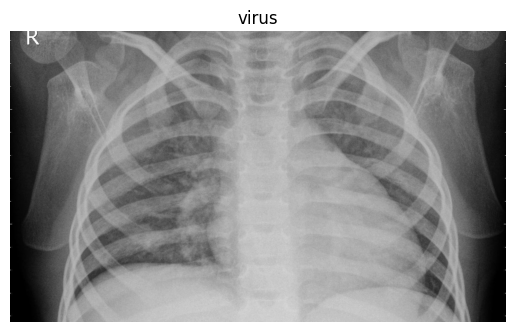

In [6]:
img = view_image("/content/COVID_IEEE/","virus")

['IM-0501-0001-0002.jpeg']
image shape (1059, 1562)


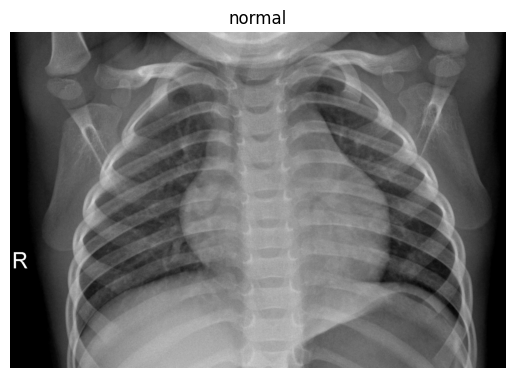

In [7]:
img = view_image("/content/COVID_IEEE/","normal")

['covid190083.png']
image shape (480, 640, 3)


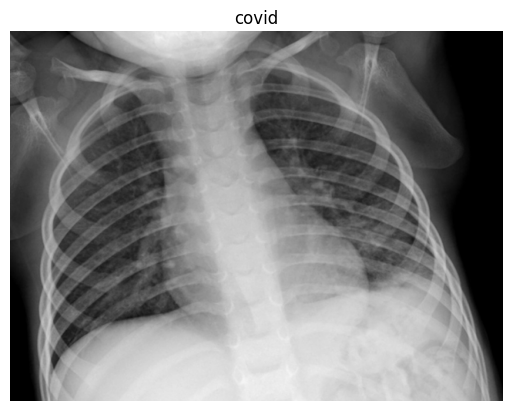

In [8]:
img = view_image("/content/COVID_IEEE/","covid")

In [ ]:
!rm -r '/content/CovidEnhanced'

 Image Enhancement uisng White Balance and Contrast Limited Adaptive Histogram Equalization
This data preprocessing step is inspired from COVIDLite Paper. In this paper, the authors used White Balance (WB) and Contrast Limited Adaptive Histogram Equalization (CLAHE) as a image preprocessing step for detection of COVID-19 cases.

2.2.1. White Balance
White Balance is the image processing operation applied to adjust proper color fidelity in a digital image. Due to low lighting conditions in medical images, some of the parts of the image appeared dark and the image capturing equipment does not detect light precisely as the human eye does. Due to this, image processing or correction help to ensure that the final image represents the colors of the natural image. The objective of this operation is to enhance the visibility of the image so that DCNNs could extract useful features from the image. The white balance algorithm adjusts the colors of the active layers of the image by stretching red, green, and blue channels independently. For doing this, pixel colors discarded, which are at the end of the three channels and are used by only 0.05% of the pixels in the image, while stretching is performed for the remaining color range. After this operation, pixel colors infrequently present at the end of the channel could not negatively influence the upper and lower bound values while stretching. In this solution, we have implemented a white balance algorithm in python language using NumPy and OpenCV library.

The steps of the White balance algorithm can be summarized as:

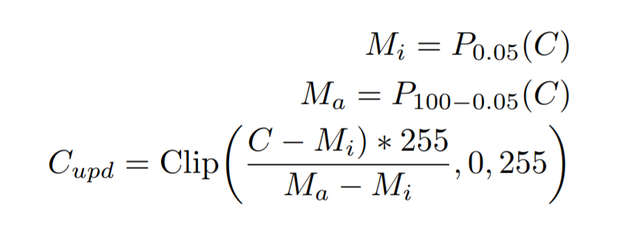

where Pi(C) represents the taking the ith percentile of channel C, and Clip(., min, max) operation depicts performing saturation operation within min and max values. C, Cupd denotes the input and updated channels pixel values after the operation respectively.

2.2.2. CLAHE (Contrast Limited Adaptive Histogram Equalization)
It is an effective contrast enhancement method that effectively increases the contrast of the image. CLAHE is an improved version of the adaptive histogram equation (AHE). Histogram equalization is the simple method for enhancing the contrast of the image by spreading out the intensity range of the image or stretching out the most frequent intensity value of the image. Stretching the intensity values changes the natural brightness of the input image and introduces some undesirable noise in the image. In AHE, the input image split into several small images, also known as tiles. In this method, the histogram of each tile computed, which corresponds to different sections of the image and uses them to derive intensity remapping function for each tile. This method introduces noise in the image due to over amplification. CLAHE works precisely the same as AHE, but it clips the histogram at specific values for limiting the amplification before computing the cumulative distributive function. The overamplified part of the histogram is further redistributed over the histogram. In one of the previous studies, CLAHE showed exceptional results in enhancing chest CT images and considered useful in examining a wide variety of medical images. The computation of CLAHE is performed as:

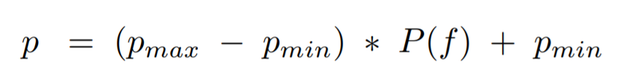

where, p represents pixel value after applying CLAHE, pmax , pmin represents maximum and minimum pixel value of an image respectively and P(f) represents cumulative probability distribution function.

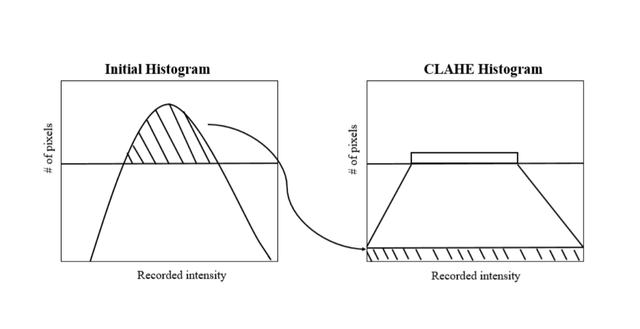



In [9]:
# data = []
# labels =[]
#cat = -1
data_source = ['/content/COVID_IEEE/covid','/content/COVID_IEEE/normal','/content/COVID_IEEE/virus']
target_dir = '/content/CovidEnhanced'
clahe =  cv2.createCLAHE(clipLimit=0.8)
for ds in data_source:
  image_files = os.listdir(ds)
  path = os.path.join(target_dir, ds.split('/')[-1])
  if os.path.isdir(path) == False :
    os.makedirs(path)
  for file in image_files:
    name = file.split('.')[0]
    filepath = os.path.join(ds,file)
    image_arr = cv2.imread(filepath)
    color_img = image_arr
    image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2GRAY)
    image_arr = clahe.apply(image_arr)
    image_arr = cv2.merge([image_arr, color_img[:,:,1], color_img[:,:,2]])
    image_arr = cv2.resize(image_arr, (224,224))
    cv2.imwrite(os.path.join(path) +"/" + name+ '.jpeg', image_arr)

['person442_virus_902.jpeg']
image shape (632, 976)


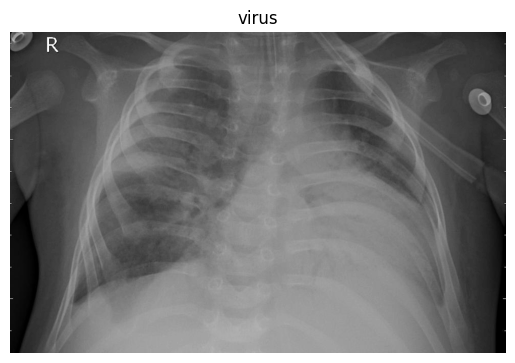

In [10]:
img = view_image("/content/COVID_IEEE/","virus")

['person673_virus_1263.jpeg']
image shape (224, 224, 3)


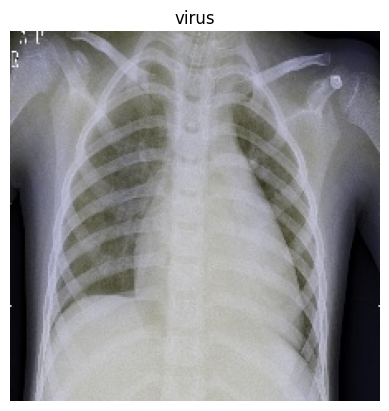

In [11]:
img = view_image("/content/CovidEnhanced/","virus")

In [12]:
!pip install split-folders

In [13]:
import splitfolders

In [14]:
splitfolders.ratio("/content/CovidEnhanced", output="CXR_Enhanced",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 1798 files [00:00, 6924.35 files/s]


In [15]:
for dirpath,dirnames,filenames in os.walk("/content/CXR_Enhanced"):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

there are 2 directories and 0 images in '/content/CXR_Enhanced'.
there are 3 directories and 0 images in '/content/CXR_Enhanced/train'.
there are 0 directories and 495 images in '/content/CXR_Enhanced/train/virus'.
there are 0 directories and 408 images in '/content/CXR_Enhanced/train/covid'.
there are 0 directories and 534 images in '/content/CXR_Enhanced/train/normal'.
there are 3 directories and 0 images in '/content/CXR_Enhanced/val'.
there are 0 directories and 124 images in '/content/CXR_Enhanced/val/virus'.
there are 0 directories and 103 images in '/content/CXR_Enhanced/val/covid'.
there are 0 directories and 134 images in '/content/CXR_Enhanced/val/normal'.


In [ ]:
data_dir = pathlib.Path("/content/CXR_Enhanced/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['covid', 'normal', 'virus'], dtype='<U6')

In [16]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu121
0.17.1+cu121


In [17]:
# Setup directory paths to train and test images
image_path = '/content/CXR_Enhanced'
train_dir = image_path +'/'+ "train"
test_dir = image_path +'/'+ "val"

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [19]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [20]:
from going_modular import data_setup

# Set the batch size
BATCH_SIZE = 64 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x795cb20bfc70>,
 ['covid', 'normal', 'virus'])

In [21]:
#Using ViT-L-16 model
from helper_functions import set_seeds

# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_L_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_l_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=1024, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_l_16-852ce7e3.pth" to /root/.cache/torch/hub/checkpoints/vit_l_16-852ce7e3.pth
100%|██████████| 1.13G/1.13G [00:06<00:00, 184MB/s]


In [22]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[242]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [23]:
from going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=3e-3,
                             )
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=90,
                                      device=device)

  0%|          | 0/90 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.3914 | train_acc: 0.8444 | test_loss: 0.2007 | test_acc: 0.9216
Epoch: 2 | train_loss: 0.1772 | train_acc: 0.9386 | test_loss: 0.1695 | test_acc: 0.9465
Epoch: 3 | train_loss: 0.1465 | train_acc: 0.9504 | test_loss: 0.1622 | test_acc: 0.9517
Epoch: 4 | train_loss: 0.1297 | train_acc: 0.9584 | test_loss: 0.1524 | test_acc: 0.9569
Epoch: 5 | train_loss: 0.1326 | train_acc: 0.9592 | test_loss: 0.1625 | test_acc: 0.9450
Epoch: 6 | train_loss: 0.1073 | train_acc: 0.9632 | test_loss: 0.1417 | test_acc: 0.9647
Epoch: 7 | train_loss: 0.1085 | train_acc: 0.9596 | test_loss: 0.1358 | test_acc: 0.9569
Epoch: 8 | train_loss: 0.1036 | train_acc: 0.9618 | test_loss: 0.1377 | test_acc: 0.9621
Epoch: 9 | train_loss: 0.1010 | train_acc: 0.9706 | test_loss: 0.1200 | test_acc: 0.9710
Epoch: 10 | train_loss: 0.0894 | train_acc: 0.9715 | test_loss: 0.1331 | test_acc: 0.9621
Epoch: 11 | train_loss: 0.0917 | train_acc: 0.9715 | test_loss: 0.1351 | test_acc: 0.9595
Epoch: 12 | train_l

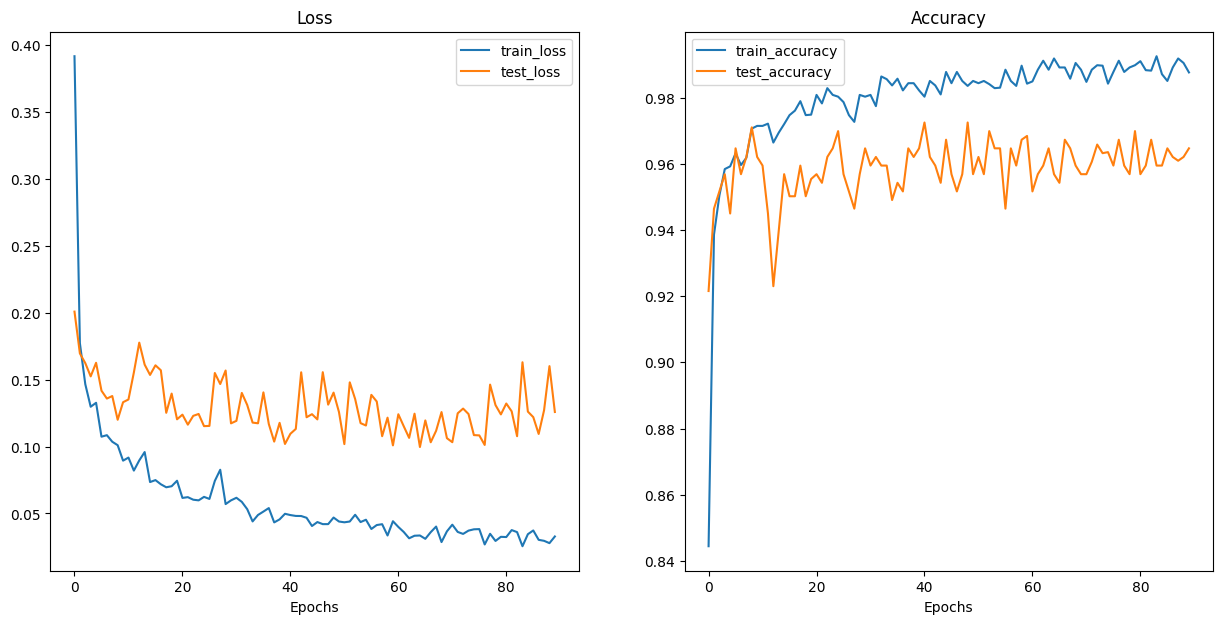

In [24]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [ ]:
#Save the best performance VIT model
from going_modular import utils

utils.save_model(model=pretrained_vit,
                target_dir="models",
                model_name="pretrained_vit_l_cxr_covid.pth")

[INFO] Saving model to: models/pretrained_vit_l_cxr_covid.pth
